# Read MNIST dataset

Dataset downloaded from *https://www.garrickorchard.com/datasets/n-mnist*

event-Python repo downloaded from github: *https://github.com/gorchard/event-Python*

In [1]:
import sys
from matplotlib import pyplot as plt
import numpy as np

sys.path.append('event-Python')

import eventvision
from spatio_temporal_feature import Feature

Event-based vision module imported


In [2]:
ev = eventvision.read_dataset(r'datasets\mnist\Test\0\00004.bin')

In [3]:
ev.show_td(100)

In [4]:
ev.data

rec.array([(18, 11, False,    581), (21, 13, False,   1703),
           (12, 24, False,   2625), ..., (21, 19,  True, 307025),
           (32, 10,  True, 307397), (10, 19,  True, 308529)],
          dtype=[('x', '<u2'), ('y', '<u2'), ('p', '?'), ('ts', '<u8')])

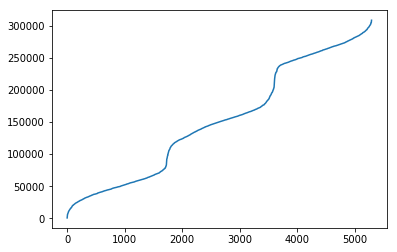

In [5]:
plt.plot([v.ts for v in ev.data])

In [8]:
# plt.plot([v.p * 1 for v in ev.data])
for i in range(100):
    print ev.data[i].p

False
False
False
False
True
False
True
True
False
False
True
False
True
False
False
False
False
False
False
True
False
True
False
True
False
False
False
False
True
True
False
False
False
False
False
False
True
False
False
False
False
False
True
True
False
False
False
False
True
True
False
False
True
False
False
True
True
False
False
True
False
False
False
False
True
False
False
True
False
True
False
False
True
True
True
True
True
False
False
True
True
True
True
False
False
False
True
False
True
True
True
False
True
False
False
True
False
False
False
False


In [9]:
len([1 for v in ev.data if not v.p])

2704

## Plot time context $\mathcal{T}_i(\mathbf{u},p)$ and time surface $\mathcal{S}_i(\mathbf{u},p)$

The time context is a 3D (2 spatial axes and 1 time) surface that indicates the most recent activations/events for each pixel at a given moment in time $i$ , within a small spatial region $\mathbf{u}$:

$$\mathcal{T}_i(\mathbf{u},p) = max_{j <= i}\{t_j | \mathbf{x}_j = (\mathbf{x}_i + \mathbf{u}), p_j = p\}$$

Note that we choose to either plot ON ($p_j = 1$) or OFF ($p_j = -1$) events, not both at the same time, just to aid visualisation.

This time-context operation is essentially a form of spatio-temporal max-pooling.


The time surface is the time context with an exponential decay applied:

$$\mathcal{S}_i(\mathbf{u},p) = e^{-(t_i - \mathcal{T}_i(\mathbf{u},p) )/\tau} $$


Text(0.5,1,'Time surface')

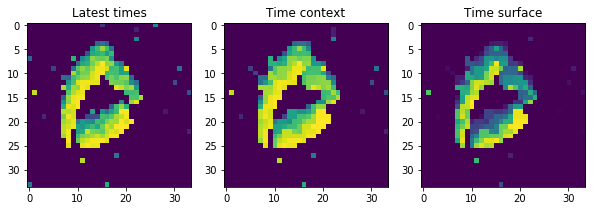

In [6]:
# %%timeit

# plot time context

feat = Feature(ev.height, ev.width, region_size=1, time_constant=10000*2)

# set time to pause at
t_pause = 70000

for e in ev.data:
    if e.ts <= t_pause:
        feat.process_event(e)
            
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(feat.latest_times_on)
ax[1].imshow(feat.time_context_on)
ax[2].imshow(feat.time_surface_on)
ax[0].set_title('Latest times')
ax[1].set_title('Time context')
ax[2].set_title('Time surface')

## Initialise time surface prototypes

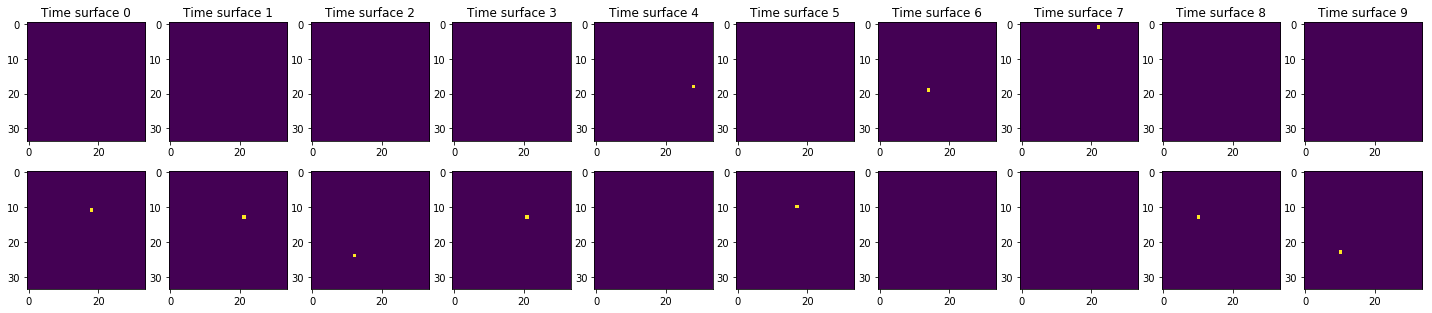

In [8]:
# Choose number of prototypes for layer 1
N_1 = 10

C_1 = [Feature(ev.height, ev.width, region_size=1, time_constant=10000*2)  for _ in range(N_1)]

# initialise and plot each of the time surface prototypes

fig, ax = plt.subplots(2, N_1, figsize=(25, 5))

for i in range(N_1):
    C_1[i].process_event(ev.data[i])

    ax[0, i].imshow(C_1[i].time_surface_on)
    ax[1, i].imshow(C_1[i].time_surface_off)
    ax[0, i].set_title('Time surface {}'.format(i))
    
plt.show()

## Train time surface prototypes for layer 1

In [136]:
# S = Feature(ev.height, ev.width, region_size=1, time_constant=10000*2)
# p = [1] * N_1

e = ev.data[1]
S.process_event(e)



# S.time_surface_off

dists = [np.linalg.norm(c_k.time_surface_off - S.time_surface_off) for c_k in C_1]

dists

k = np.argmin(dists)

k

alpha = 0.01 / (1 + p[k] / 2000.)

alpha

beta = np.dot(C_1[k].time_surface_off, S.time_surface_off) / (np.linalg.norm(C_1[k].time_surface_off) * np.linalg.norm(S.time_surface_off))

beta

C_1[k].time_surface_off += alpha * (S.time_surface_off - beta * C_1[k].time_surface_off)

C_1[k].time_surface_off

p[k] += 1

p

[2, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [171]:
ev.data[90:110]

rec.array([(21, 12,  True, 19379), (20, 20, False, 19416),
           (12, 20,  True, 19450), (21, 19, False, 19450),
           (21, 18, False, 19655), (19,  9,  True, 19680),
           (11, 13, False, 19903), ( 8, 19, False, 20072),
           ( 8, 22, False, 20093), (17, 22, False, 20098),
           (14, 20,  True, 20116), (18, 13, False, 20143),
           (11, 14, False, 20198), (12, 24, False, 20206),
           (15, 19,  True, 20278), (16,  4,  True, 20314),
           ( 7, 15,  True, 20693), (10, 23, False, 20709),
           (13,  7,  True, 20795), (12,  8,  True, 20924)],
          dtype=[('x', '<u2'), ('y', '<u2'), ('p', '?'), ('ts', '<u8')])

In [9]:
# initialise time surface
S = Feature(ev.height, ev.width, region_size=1, time_constant=10000*2)

p = [1] * N_1

for e in ev.data[:88]:
    S.process_event(e)
    
    if e.p:
        # find closest cluster center (i.e. closest time surface prototype, according to euclidean distance)
    
        dists = [np.linalg.norm(c_k.time_surface_on - S.time_surface_on) for c_k in C_1]

        k = np.argmin(dists)

        # update prototype that is closest to

        alpha = 0.01 / (1 + p[k] / 2000.)
        beta = np.dot(C_1[k].time_surface_on, S.time_surface_on) / (np.linalg.norm(C_1[k].time_surface_on) * np.linalg.norm(S.time_surface_on))

        C_1[k].time_surface_on += alpha * (S.time_surface_on - beta * C_1[k].time_surface_on)
        
        p[k] += 1
    else:
        # find closest cluster center (i.e. closest time surface prototype, according to euclidean distance)
    
        dists = [np.linalg.norm(c_k.time_surface_off - S.time_surface_off) for c_k in C_1]

        k = np.argmin(dists)

        # update prototype that is closest to

        alpha = 0.01 / (1 + p[k] / 2000.)
        beta = np.dot(C_1[k].time_surface_off, S.time_surface_off) / (np.linalg.norm(C_1[k].time_surface_off) * np.linalg.norm(S.time_surface_off))

        C_1[k].time_surface_off += alpha * (S.time_surface_off - beta * C_1[k].time_surface_off)
        
        p[k] += 1
    
print k
print(e, dists, k, alpha, beta, p)


4
((9, 14, False, 19146), [19.888186005268366, 18.091249703000905, 16.69005826690113, 14.370526362993957, 13.972092680664598, 14.471138436353641, 13.972092680664598, 13.972092680664598, 14.454904645463346, 14.452410694150084], 4, 0.009975062344139652, array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]]), [2, 2, 2, 3, 6, 13, 15, 15, 19, 21])


C:\Users\Shaun\Miniconda3\envs\neuro27_env\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in divide


In [193]:
k

4

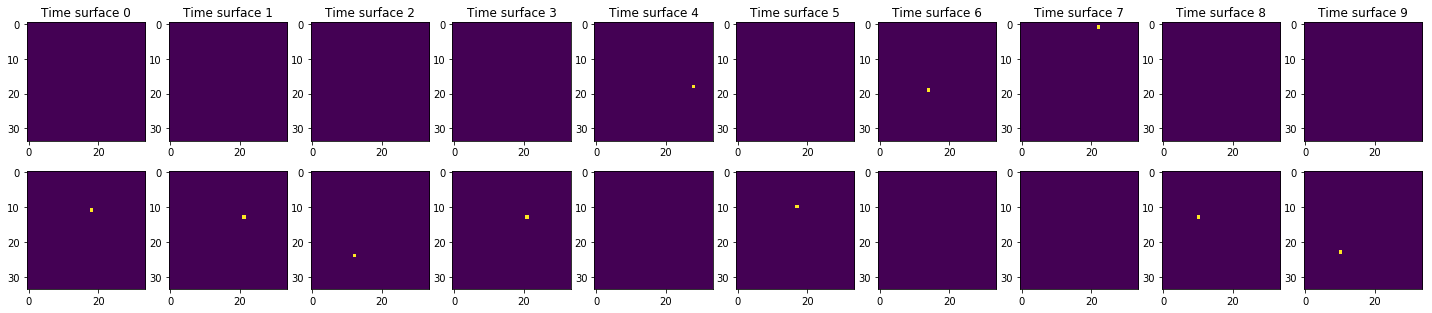

In [110]:
fig, ax = plt.subplots(2, N_1, figsize=(25, 5))

for i in range(N_1):
    C_1[i].process_event(ev.data[i])

    ax[0, i].imshow(layer_1[i].time_surface_on)
    ax[1, i].imshow(layer_1[i].time_surface_off)
    ax[0, i].set_title('Time surface {}'.format(i))
    
plt.show()